In [25]:
import numpy as np

def explore_citymask(index):

    #-----------------------------------------------
    # Initialization
    #-----------------------------------------------

    # map data
    MAP='CAMA'

    # initial radius from central point
    radius = 1

    # explore grid radius
    radius_max = 12

    # shape
    lat_shape = 2160
    lon_shape = 4320

    # date type
    dtype= 'float32'

    # h08 directory
    h08dir = '/home/kajiyama/H08/H08_20230612'

    # initialize variables
    best_coverage = float('inf')
    best_mask = None
    best_masked_pop = None

    #-----------------------------------------------
    # load true data (UN city list) unit=[1000person]
    #-----------------------------------------------

    # true population and city name
    un_pop_list = []
    name_list = []

    # load data
    inf_path = h08dir + '/map/dat/cty_lst_/city_list03.txt'
    for l in open(inf_path).readlines():
        data = l[:-1].split('	')
        un_pop_list.append(int(data[4]))
        name_list.append(data[5])

    # get true UN city population
    un_pop = un_pop_list[index-1]*1000

    # get city name
    city_name = name_list[index-1]

    #-----------------------------------------------
    #  Get area(m2)
    #-----------------------------------------------

    area = np.fromfile(h08dir + f'/map/dat/lnd_ara_/lndara.{MAP}.gl5', dtype=dtype).reshape(lat_shape, lon_shape)

    #-----------------------------------------------
    # load gwp population data
    #-----------------------------------------------

    # population data(GWP4 2000)
    gwp_pop = np.fromfile(h08dir + '/map/dat/pop_tot_/C05_a___20000000.gl5', dtype=dtype).reshape(lat_shape, lon_shape)

    # population density (person/km2)
    gwp_pop_density = (gwp_pop / (area / 10**6))

    #-----------------------------------------------
    # load city_center coordinate
    #-----------------------------------------------

    location = np.fromfile(h08dir + f'/map/dat/cty_cnt_/city_{index:08d}.gl5',dtype=dtype).reshape(lat_shape,lon_shape)
    x = np.where(location==1)[0]
    y = np.where(location==1)[1]
    x = x[0]
    y = y[0]

    #-----------------------------------------------
    # check city center
    #-----------------------------------------------

    # original city center
    org_cnt = gwp_pop[x, y]

    # search radius
    circle = 3

    # number of replacement
    replaced_num = 0
    
    # if there is larger grid, center grid is replaced
    for a in range(x-circle, x+circle+1):
        for b in range(y-circle, y+circle+1):
            candidate = gwp_pop[a, b]
            if candidate >= org_cnt:
                org_cnt = candidate
                x = a
                y = b
                replaced_num += 1
                print(f'city center is replaced {replaced_num}')

    #-----------------------------------------------
    #  Make save array
    #-----------------------------------------------

    # mask array for saving
    mask = np.zeros((lat_shape,lon_shape), dtype=dtype)
    mask[x,y] = 1
    
    #-----------------------------------------------
    #  Explore start
    #-----------------------------------------------

    # stop flag
    new_mask_added = True
    coverage_flag = True
    print(f'processing the city {city_name}...')

    while new_mask_added:
        # make search list
        search_lst = []
        new_mask_added = False
        for a in range(max(0, x - radius_max), min(x + radius_max + 1, lat_shape)):
            for b in range(max(0, y - radius_max), min(y + radius_max + 1, lon_shape)):
                if mask[a, b] == 1:
                    # explore surrounded 8 grids
                    for dx, dy in [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, 1)]:
                        i, j = a + dx, b + dy
                        # not explored yet
                        if mask[i, j] == 0:
                            # within grid range
                            if 0 <= i < lat_shape and 0<= j < 4320:
                                search_lst.append([gwp_pop[i, j], i, j])
                                    
        # add searched grid
        sorted_search = sorted(search_lst, key=lambda x: x[0], reverse=True) 
        if coverage_flag is True:
            largest = sorted_search[0]
            mask[largest[1], largest[2]] = 1
            new_mask_added = True

            # evaluate coverage
            gwp_masked_pop = np.sum(mask * gwp_pop)
            coverage = float(gwp_masked_pop / un_pop)

            # stop exploring
            if coverage >= 1.0:
                new_mask_added = False
                coverage_flag = False

            # judge
            judge_value = abs(1 - coverage)
            best_value = abs(1 - best_coverage)

            # update
            if judge_value < best_value:
                best_coverage = coverage
                best_mask = mask
                best_masked_pop = gwp_masked_pop
                grid_num = np.sum(best_mask)
                
            print(best_coerage)

    #-----------------------------------------------
    # Output result
    #-----------------------------------------------

    print('#########################################')
    print('#########################################')
    print(f"cityindex {index}\n" \
          f"explored_pop {best_masked_pop}\n" \
          f"true_pop {un_pop}\n" \
          f"coverage {best_coverage}\n" \
          f"city_mask {grid_num}\n" \
          f"{city_name}\n")
    print('#########################################')
    print('#########################################\n')
    
    return best_mask


def main():
    for index in range(1, 2):
        best_mask = explore_citymask(index)
    
    return best_mask

In [26]:
best_mask = main()

city center is replaced 1
processing the city Tokyo...


NameError: name 'sorted_searched' is not defined

In [23]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cmaps
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
import cartopy.feature as cfea

def get_coordinate(city_index):
    # open city information text
    city_path = '/home/kajiyama/H08/H08_20230612/map/dat/cty_lst_/cityrange_list_temp.txt'
    with open(city_path, "r") as file:
        all_lines = file.readlines()
    # get city
    line = all_lines[city_index - 1]
    line = line.strip()
    parts = line.split()
    
    city_num = parts[0].zfill(3)
    city = parts[5].replace("\"", "").replace("?", "").replace("/", "")
    
    lonmin = float(parts[6])
    lonmax = float(parts[7])
    latmin = float(parts[8])
    latmax = float(parts[9])

    # Dimension of the data
    a = 2160
    b = 4320

    ### Define the latitudes and longitudes
    # West from UK is negative 0 <= lon <= -180
    # East from UK is positive 0 <= lon <= 180
    # small value to larger value (34-36, 138-140)
    lat = np.linspace(-90, 90, a+1)
    lon = np.linspace(-180, 180, b+1)

    # calculate the indices correspondignt to the desired lat and lon
    lat_start, lat_end = np.searchsorted(lat, [latmin, latmax])
    lon_start, lon_end = np.searchsorted(lon, [lonmin, lonmax])

    ### adjust to 0.25 grid
    # lat
    if lat_start%3 == 0:
        lat_start = lat_start
    elif lat_start%3 == 1:
        lat_start -= 1
    elif lat_start%3 == 2:
        lat_start += 1

    # lon
    if lon_start%3 == 0:
        lon_start = lon_start
    elif lon_start%3 == 1:
        lon_start -= 1
    elif lon_start%3 == 2:
        lon_start += 1

    # 24 grid x 24 grid
    lat_end = lat_start + 24
    lon_end = lon_start + 24

    # convert real lonlat to h08 lonlat
    latmin_gl5 = lat[lat_start]
    latmax_gl5 = lat[lat_end]
    lonmin_gl5 = lon[lon_start]
    lonmax_gl5 = lon[lon_end]
    
    return lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5

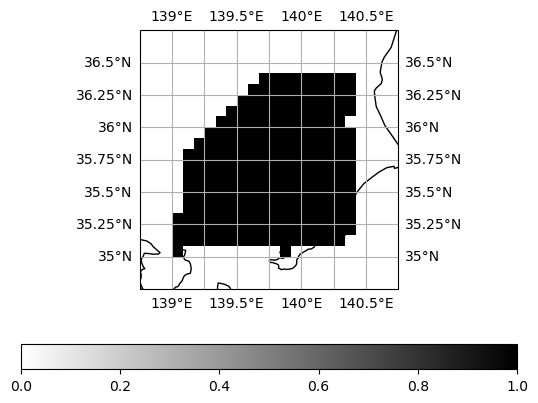

In [24]:
#-----------------------------------------------
# Draw city mask
#-----------------------------------------------
# city index
index = 1

# get city lonlat
lat_start, lat_end, lon_start, lon_end, latmin_gl5, latmax_gl5, lonmin_gl5, lonmax_gl5 = get_coordinate(index)

# crop
mask_flipped = np.flipud(best_mask)
mask_cropped = mask_flipped[lat_start:lat_end, lon_start:lon_end]
cropped_flipped = np.flipud(mask_cropped)

# extent
projection = ccrs.PlateCarree()
img_extent = (lonmin_gl5, lonmax_gl5, latmin_gl5, latmax_gl5)

# figure
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(cropped_flipped,
               origin='upper',
               extent=img_extent,
               transform=projection,
               cmap='gray_r')
fig.colorbar(im, ax=ax, orientation='horizontal')